In [1]:
import tensorflow as tf
import pandas as pd
import os
import tensorflow_addons as tfa
import cv2
import glob

from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import patches
from tensorflow.python.ops.numpy_ops import np_config
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
#from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
from tensorflow.keras.layers import *
from keras_unet_collection import models



from src.swin_transformer.model import *
from src.swin_transformer.helper import *
from src.swin_transformer.patches import *
from src.swin_transformer.window_attn import *
from src.data_prepare import preprocess_data
from src.utils import *


/tmp/ipykernel_595587/611525214.py:18: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [2]:
#K.set_image_dim_ordering('th')
np_config.enable_numpy_behavior()

# Data errors

In [3]:
annot_df = {'img_name' : [],'classes' : [],'x' : [],'y' : [],'width' : [],'height' : []}
sample = {'image' : [],'bbox' : [],'label' : []}
empty_list = []
for idx,i in tqdm(enumerate(os.listdir('kaggle/train/labels/'))):
    ## Empty Labels
    try:
        tmp_df = pd.read_csv(f'kaggle/train/labels/{i}',header=None)
        for j in tmp_df[0].values:
            annot_df['img_name'].append(f'kaggle/train/images/{i.split(".")[0]}.png')
            #sample['image'] = Image.open(f'kaggle/train/images/{i.split(".")[0]}.png').convert('RGB')
            annot_df['classes'].append(j.split()[0])
            annot_df['x'].append(j.split()[1])
            annot_df['y'].append(j.split()[2])
            annot_df['width'].append(j.split()[3])
            annot_df['height'].append(j.split()[4])
            ###
            sample['label'].append(j.split()[0])
            sample['bbox'].append(j.split()[1])
            sample['bbox'].append(j.split()[2])
            sample['bbox'].append(j.split()[3])
            sample['bbox'].append(j.split()[4])
    except pd.errors.EmptyDataError:
        empty_list.append(i)
        continue

2474it [00:01, 1502.68it/s]


In [4]:
empty_list

['07081.txt',
 '02528.txt',
 '04966.txt',
 '06229.txt',
 '04285.txt',
 '03798.txt',
 '02448.txt']

In [5]:
df = pd.DataFrame.from_dict(annot_df)


## Plot Images

In [6]:
def plot_image(value=0):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Load Image 
    image = Image.open(annot_df['img_name'][value])

    # Load all objects
     
    tmp_df = df.query(f"img_name == '{annot_df['img_name'][value]}'")

    for idx, rows in tmp_df.iterrows():

        # Load xy, width and height
        x = (float(rows['x']) - float(rows['width']) * 0.5) * image.size[0]
        y = (float(rows['y']) - float(rows['height']) * 0.5) * image.size[1]
        width = float(rows['width']) * image.size[0]
        height = float(rows['height']) * image.size[1]
        
        # Dsiplay the image
        ax.imshow(image)

        # Create a Rectangle patch
        rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    plt.show()

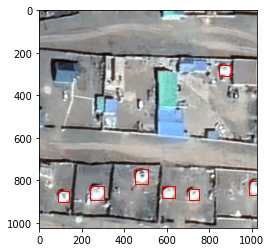

In [7]:
plot_image(0)

In [8]:
def plot_resized_image(resize_size:tuple,value=0):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Load Image 
    image = Image.open(annot_df['img_name'][value])

    # Resize image
    image = tf.image.resize_with_pad(image,resize_size[0],resize_size[1])
    image = image.astype(np.uint8)

    # Load all objects
     
    tmp_df = df.query(f"img_name == '{annot_df['img_name'][value]}'")

    for idx, rows in tmp_df.iterrows():

        # Load xy, width and height
        x = (float(rows['x']) - float(rows['width']) * 0.5) * resize_size[0]
        y = (float(rows['y']) - float(rows['height']) * 0.5) * resize_size[1]
        width = float(rows['width']) * resize_size[0]
        height = float(rows['height']) * resize_size[1]
        
        # Dsiplay the image
        ax.imshow(image)

        # Create a Rectangle patch
        rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    plt.show()

2022-05-31 10:00:25.267507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 10:00:25.268334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 10:00:25.272666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 10:00:25.273507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 10:00:25.274282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

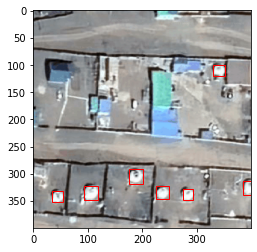

In [9]:
plot_resized_image((400,400),0)

In [10]:
df

,img_name,classes,x,y,width,height
0,kaggle/train/images/04320.png,0,0.981836,0.815967,0.036328,0.067676
1,kaggle/train/images/04320.png,0,0.593945,0.836572,0.059375,0.056152
2,kaggle/train/images/04320.png,0,0.470215,0.762305,0.062695,0.069336
3,kaggle/train/images/04320.png,0,0.264795,0.839844,0.064355,0.066016
4,kaggle/train/images/04320.png,0,0.111328,0.854736,0.051172,0.052832
...,...,...,...,...,...,...
23450,kaggle/train/images/01431.png,0,0.901563,0.052295,0.129297,0.104590
23451,kaggle/train/images/01431.png,0,0.543652,0.027588,0.131445,0.055176
23452,kaggle/train/images/00666.png,0,0.848437,0.108545,0.137109,0.137012
23453,kaggle/train/images/05487.png,0,0.958496,0.692871,0.083008,0.102539


In [11]:
def convert_bbox(x):
    img = Image.open(x['img_name'])
    #sizes = img.size
    # Load xy, width and height
    x_mod = (float(x['x']) - float(x['width']) * 0.5) * img.size[0]
    y_mod = (float(x['y']) - float(x['height']) * 0.5) * img.size[1]
    width_mod = float(x['width']) * img.size[0]
    height_mod = float(x['height']) * img.size[1]
    return pd.Series([x_mod,y_mod,width_mod,height_mod],index=['x_mod','y_mod','width_mod','height_mod'])

In [12]:
df[['x_mod','y_mod','width_mod','height_mod']] = df.apply(lambda x: convert_bbox(x),axis=1)
df[['x_mod','y_mod','width_mod','height_mod']] = df[['x_mod','y_mod','width_mod','height_mod']].astype(int)

In [13]:
df['xmin'] = df['x_mod']
df['xmax'] = df['xmin'] + df['width_mod']
df['ymin'] = df['y_mod']
df['ymax'] = df['ymin'] + df['height_mod']

(-0.5, 1075.225, 1075.225, -0.5)

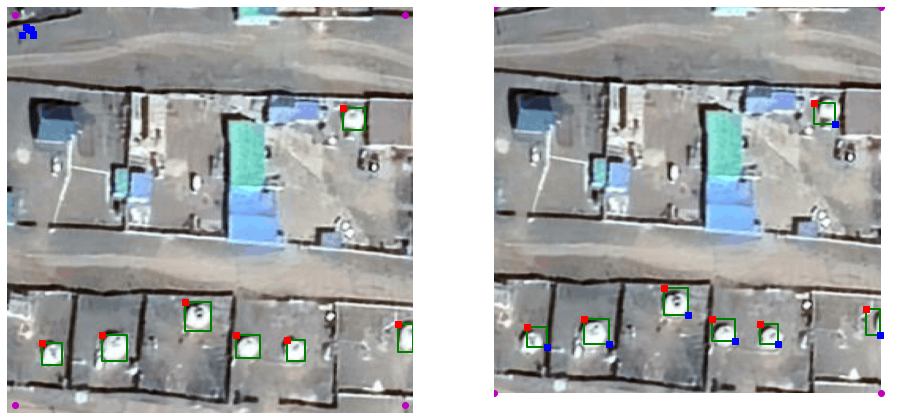

In [14]:

#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df,1,augmentation=False,trans_range=0,scale_range=0)
img_mask =get_mask_seg(img,bb_boxes)

tr_x1 = 20
tr_y1 = 20
tr_x2 = 20
tr_y2 = 20



p1 = (tr_x1,tr_y1)
p2 = (img.shape[1]-tr_x2,tr_y1)

p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
p4 = (tr_x1,img.shape[0]-tr_y2)

pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],[0,img.shape[0]] ]
                   )

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
dst = np.array(dst,dtype=np.uint8)


plt.figure(figsize=(16,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.plot(p1[0],p1[1],'mo')
plt.plot(p2[0],p2[1],'mo')
plt.plot(p3[0],p3[1],'mo')
plt.plot(p4[0],p4[1],'mo')
for i in range(len(bb_boxes)):
    plot_bbox(bb_boxes,i,'g')
    
    bb_box_i = [bb_boxes.iloc[i]['x_mod'],bb_boxes.iloc[i]['y_mod'],
                bb_boxes.iloc[i]['width_mod'],bb_boxes.iloc[i]['height_mod']]
    plt.plot(bb_box_i[0],bb_box_i[1],'rs')
    plt.plot(bb_box_i[2],bb_box_i[3],'bs')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dst)
bb_boxes1 = bb_boxes.copy(deep=True)
bb_boxes1['x_mod'] = (bb_boxes['x_mod'] - p1[1])/(p2[1]-p1[1])*img.shape[0]
bb_boxes1['y_mod'] = (bb_boxes['y_mod'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['width_mod'] = (bb_boxes['width_mod'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
bb_boxes1['height_mod'] = (bb_boxes['height_mod'] - p1[0])/(p3[0]-p1[0])*img.shape[1]
plt.plot(0,0,'mo')
plt.plot(img.shape[1],0,'mo')
plt.plot(img.shape[1],img.shape[0],'mo')
plt.plot(0,img.shape[0],'mo')
plot_im_bbox(dst,bb_boxes1)

plt.axis('off')

In [15]:
len(img_mask[0])

1024

(-0.5, 1023.5, 1023.5, -0.5)

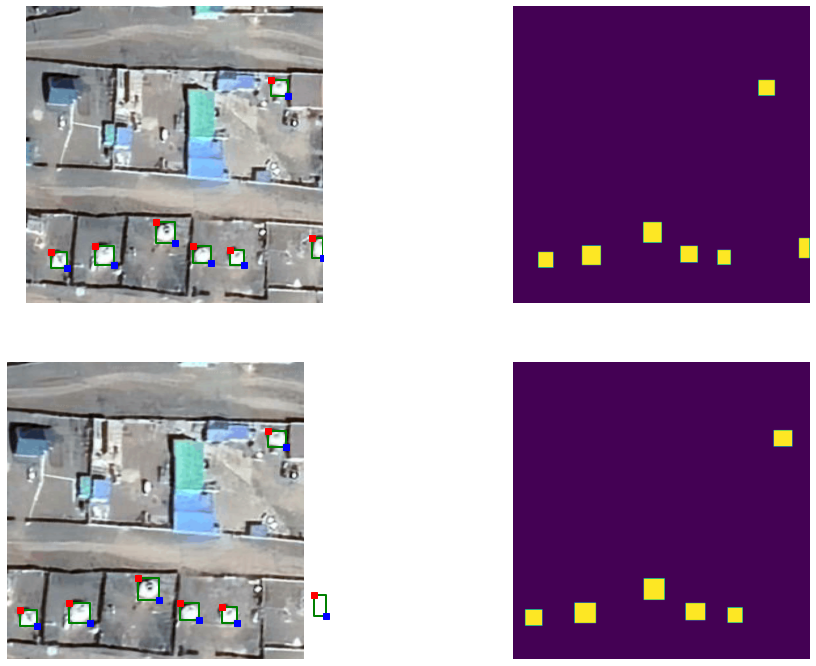

In [16]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
dst,bb_boxes1 = stretch_image(img,bb_boxes,100)

plt.imshow(dst)

plot_im_bbox(dst,bb_boxes1)

plt.subplot(2,2,4)
img_mask2 =get_mask_seg(dst,bb_boxes1)
plt.imshow(img_mask2[:,:,0])
plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

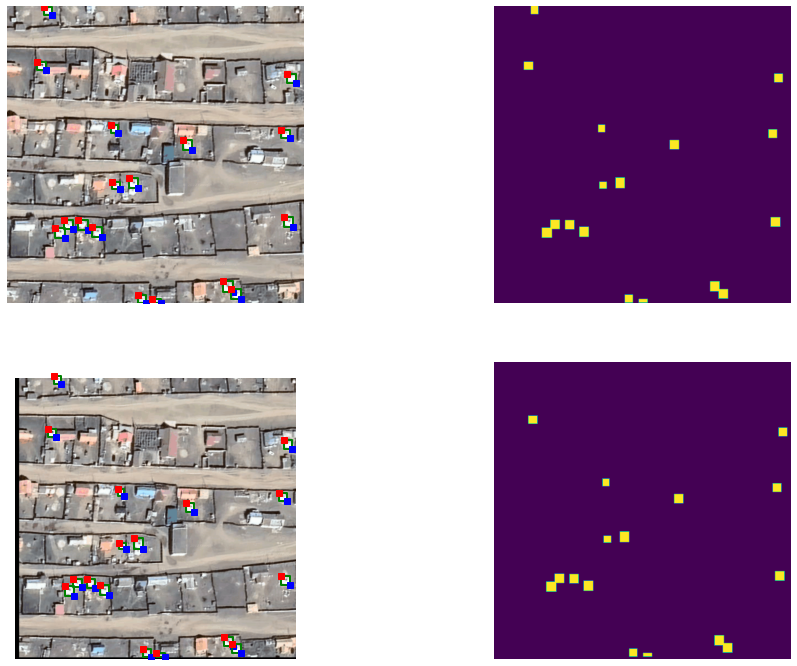

In [17]:
### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df,200,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,100)

plt.imshow(img_trans)

plot_im_bbox(img_trans,bb_boxes1)
img_mask2 =get_mask_seg(img_trans,bb_boxes1)

plt.subplot(2,2,4)
plt.imshow(img_mask2[:,:,0])
plt.axis('off')

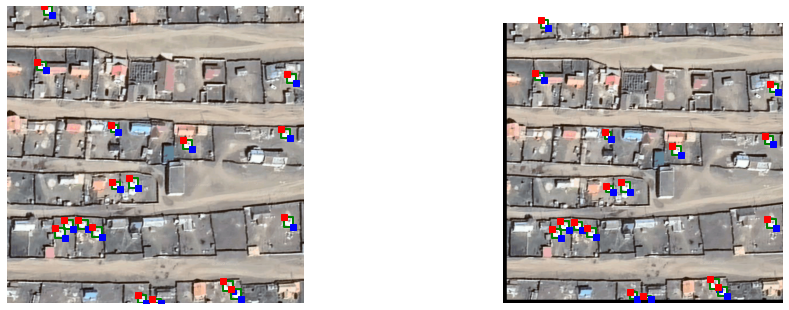

In [18]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)
plt.subplot(2,2,2)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,50)
plt.imshow(img_trans)
plot_im_bbox(img_trans,bb_boxes1)

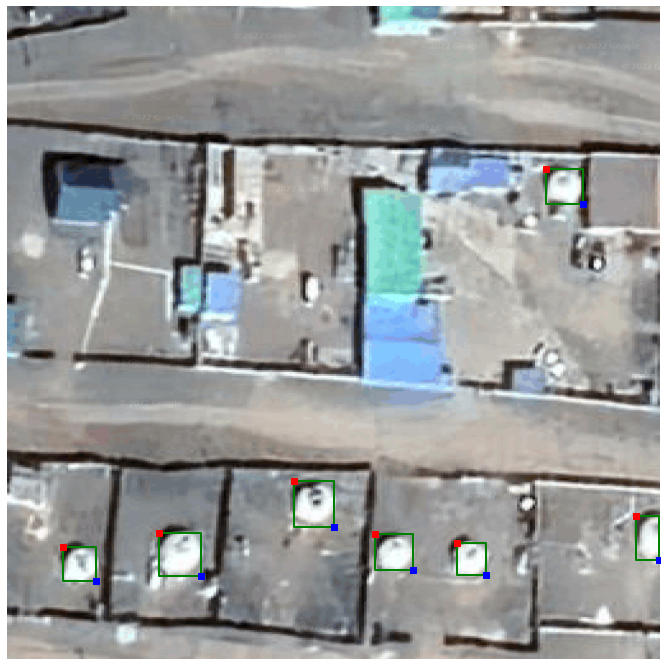

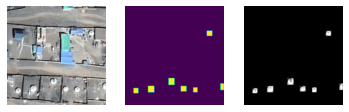

In [19]:
#### Put all the augmentations in 1 function with a flag for augmentation


name_str,img,bb_boxes = get_image_name(df,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)


plt.figure(figsize=(16,12))
plt.imshow(img)
plot_im_bbox(img,bb_boxes)
plt.show()

plot_im_mask(img,img_mask)

## Prepare data

In [50]:
#### Training generator, generates augmented images
def generate_train_batch(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, 256, 256, 3))
    batch_masks = np.zeros((batch_size, 256, 256, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data)-2000)
            name_str,img,bb_boxes = get_image_name(df,i_line,
                                                   size=(256, 256),
                                                  augmentation=True,
                                                   trans_range=50,
                                                   scale_range=50
                                                  )
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks
        
#### Testing generator, generates augmented images
def generate_test_batch(data,batch_size = 32):
    batch_images = np.zeros((batch_size, 256, 256, 3))
    batch_masks = np.zeros((batch_size, 256, 256, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(2000)
            i_line = i_line+len(data)-2000
            name_str,img,bb_boxes = get_image_name(df,i_line,
                                                   size=(256, 256),
                                                  augmentation=False,
                                                   trans_range=0,
                                                   scale_range=0
                                                  )
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks

In [51]:
##### Testing the generator

training_gen = generate_train_batch(df,10)

In [52]:
batch_img,batch_mask = next(training_gen)

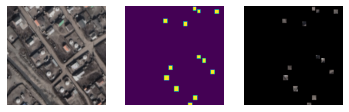

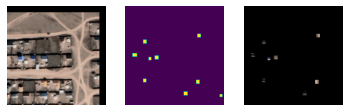

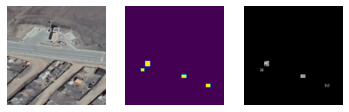

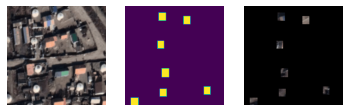

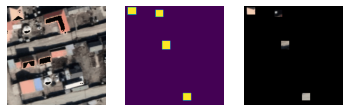

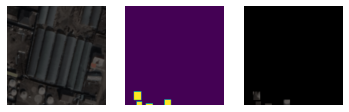

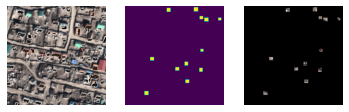

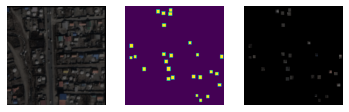

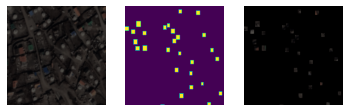

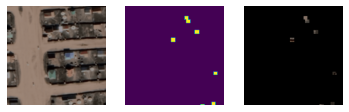

In [53]:
### Plotting generator output
for i in range(10):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask))
    plt.axis('off')
    plt.show()

## Prepare IOU Loss

In [54]:
### IOU or dice coeff calculation

def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [55]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [56]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((512, 512, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [57]:
K.set_image_data_format('channels_last')

In [58]:
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_function(get_iou_vector, [label, pred > 0.5], tf.float64)

In [59]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [60]:
### Generator 

training_gen = generate_train_batch(df,8)
smooth = 1.
model = UNet()
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), 
#              loss=IOU_calc_loss, metrics=[IOU_calc])
model.compile(loss=bce_dice_loss,
              optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              metrics=[IOU_calc]
              )

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [61]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 512, 512, 16  448         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_38[0][0]']              
                                )                                                           

In [62]:
len(df)

23455

In [33]:
23455/8

2931.875

In [34]:
history = model.fit(training_gen,
                    #batch_size=32,
                    steps_per_epoch=3000,
                    epochs=5)

Epoch 1/5


2022-05-31 09:45:57.629989: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8400


3000/3000 [==============================] - 772s 256ms/step - loss: 0.8539 - IOU_calc: 0.2563
Epoch 2/5
  15/3000 [..............................] - ETA: 12:52 - loss: 0.8046 - IOU_calc: 0.2919

KeyboardInterrupt: 

In [63]:
model = models.swin_unet_2d((256, 256, 3), filter_num_begin=64, n_labels=1, depth=4, stack_num_down=2, stack_num_up=2, 
                            patch_size=(2, 2), num_heads=[4, 8, 8, 8], window_size=[4, 2, 2, 2], num_mlp=512, 
                            output_activation='Sigmoid', shift_window=True, name='swin_unet')

In [64]:
model.compile(loss=bce_dice_loss,
              optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              metrics=[IOU_calc]
              )

In [65]:
history = model.fit(training_gen,
                    #batch_size=32,
                    steps_per_epoch=3000,
                    epochs=5)

Epoch 1/5
1937/3000 [==================>...........] - ETA: 4:51 - loss: 1.2113 - IOU_calc: 0.0280

KeyboardInterrupt: 